In [1]:
import pandas as pd
import re

#Read the data from csv into dataframe
LGA_INFO = pd.read_csv('Data/LGA_2016_VIC.csv')
LGA_SPORT_FACILITY = pd.read_csv('Data/Victoria_Sport_and_Recreation_Facility_Location.csv')
LGA_HEALTH_RISK = pd.read_csv('Data/LGA15_Adults_Health_Risk_Factor_Estimates.csv')

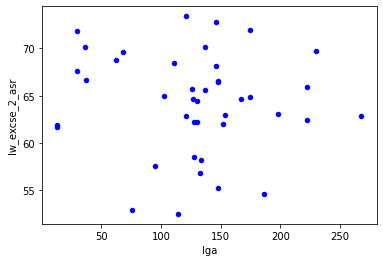

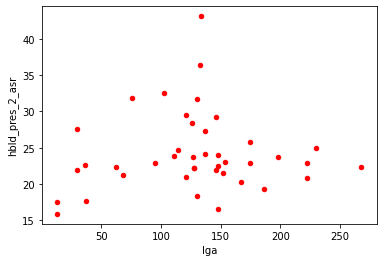

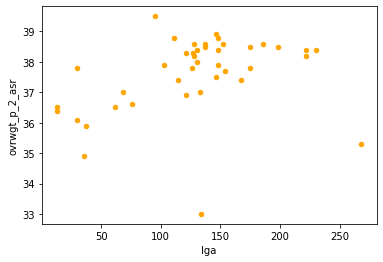

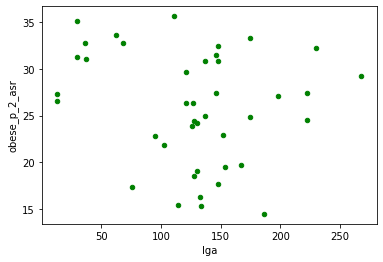

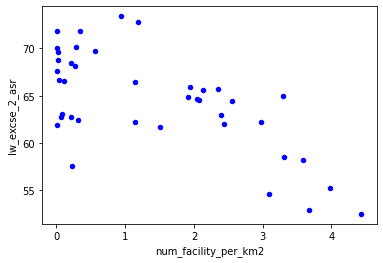

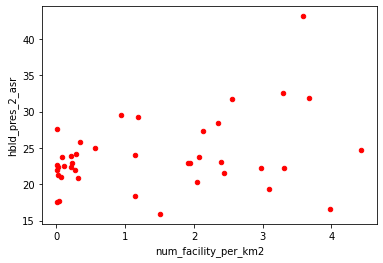

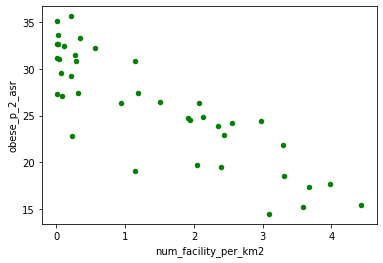

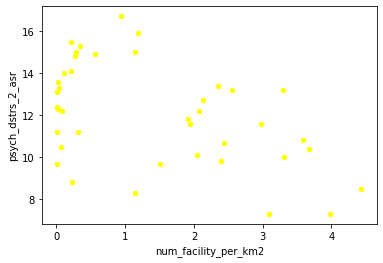

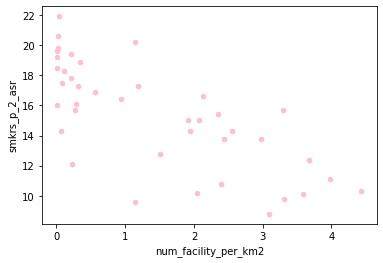

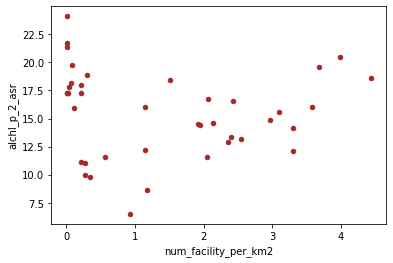

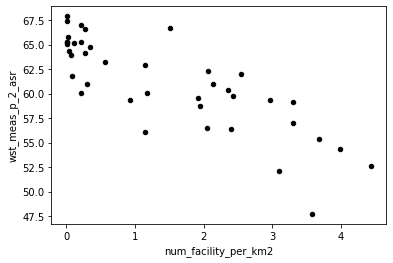

In [2]:
#Cleaning area name and corresponding area code, and make a dictionary
LGA_NAME_TO_CODE = LGA_INFO[['LGA_CODE_2016', 'LGA_NAME_2016']]
LGA_NAME_TO_CODE = LGA_NAME_TO_CODE.drop_duplicates()
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.replace(r' \([^()]*\)', '', regex=True)
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.upper()
LGA_DIC = LGA_NAME_TO_CODE.set_index('LGA_NAME_2016')['LGA_CODE_2016'].to_dict()

#Find the corresponding area codes for the sport facilities
area_code = LGA_SPORT_FACILITY['lga'].to_list()
for i in range(len(area_code)):
    if area_code[i] in LGA_DIC:
        area_code[i] = LGA_DIC[area_code[i]]
    else:
        area_code[i] = None

#Print the area names that does not have a corresponding code
# for i in range(len(area_code)):
#     if area_code[i] == None:
#         print(LGA_SPORT_FACILITY['lga'].to_list()[i])

#Add the area codes and clean the sport facility dataframe
LGA_SPORT_FACILITY['lga_code'] = area_code
LGA_SPORT_FACILITY = LGA_SPORT_FACILITY.dropna(subset=['lga_code'])
LGA_SPORT_FACILITY['lga_code'] = LGA_SPORT_FACILITY['lga_code'].astype(dtype='int')

#Group the sport facilities by area code
FACILITY_COUNT_PER_LGA = LGA_SPORT_FACILITY.groupby('lga_code', as_index=False).count()[['lga_code', 'lga']]
#print(FACILITY_COUNT_PER_LGA)

#Join the sport facility dataframe and health risk dataframe together by lga
JOINED = FACILITY_COUNT_PER_LGA.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)
# print(JOINED)

plot1 = JOINED.plot.scatter(x='lga', y='lw_excse_2_asr', c='Blue')
plot2 = JOINED.plot.scatter(x='lga', y='hbld_pres_2_asr', c='Red')
plot3 = JOINED.plot.scatter(x='lga', y='ovrwgt_p_2_asr', c='Orange')
plot4 = JOINED.plot.scatter(x='lga', y='obese_p_2_asr', c='Green')

#Read region population csv
region_population = pd.read_csv('Data/regional_population_csv.csv')

#Join region_population dataframe and JOINED together by lga code
JOINED_2 = JOINED.join(region_population.set_index('lga_code'), on='lga_code', how='left', sort=False)
JOINED_2['num_facility_per_capita(2016)']=JOINED_2['lga']/JOINED_2['population2016']
JOINED_2['num_facility_per_capita(2017)']=JOINED_2['lga']/JOINED_2['population2017']
JOINED_2['num_facility_per_km2']=JOINED_2['lga']/JOINED_2['Area(km2)']

# Remove one outlier with num_facility_perr_km2 > 5
JOINED_2 = JOINED_2[JOINED_2['num_facility_per_km2']<5]

plot5 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='lw_excse_2_asr', c='Blue')
plot6 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='hbld_pres_2_asr', c='Red')
plot8 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='obese_p_2_asr', c='Green')
plot9 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='psych_dstrs_2_asr', c='Yellow')
plot11 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='smkrs_p_2_asr', c='Pink')
plot12 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='alchl_p_2_asr', c='Brown')
plot13 = JOINED_2.plot.scatter(x='num_facility_per_km2', y='wst_meas_p_2_asr', c='Black')

**Regression for lw_excse_2_asr**

Linear

[[ 1.         -0.66308798]
 [-0.66308798  1.        ]]
Coefficients:  [-2.5455855]

Intercept:  68.0385238235378

Coefficient of determination: 0.44


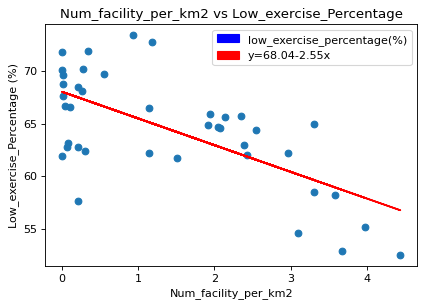

In [35]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing

X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['lw_excse_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['lw_excse_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
from matplotlib.pyplot import figure
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['low_exercise_percentage(%)','y=68.04-2.55x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num_facility_per_km2 vs Low_exercise_Percentage")
plt.ylabel("Low_exercise_Percentage (%)")
plt.xlabel("Num_facility_per_km2")
plt.show()
plt.savefig("Low_exercise_linear")

quadratic

Coefficients:  [ 0.         -3.81743249  0.04038478]

Intercept:  31.314464499689993

Coefficient of determination: 0.73


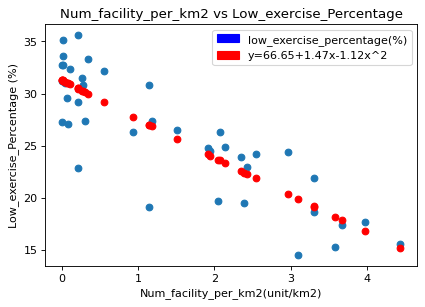

In [34]:
from sklearn.preprocessing import PolynomialFeatures

# quadratic linear regression 
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['low_exercise_percentage(%)','y=66.65+1.47x-1.12x^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num_facility_per_km2 vs Low_exercise_Percentage")
plt.ylabel("Low_exercise_Percentage (%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.show()
plt.savefig("Low_exercise_quadratic")

quadratic model provides a better fit

**Regression for obese_p_2_asr**

Linear

[[ 1.         -0.85585843]
 [-0.85585843  1.        ]]
Coefficients:  [-3.67266748]

Intercept:  31.26426626437196

Coefficient of determination: 0.73


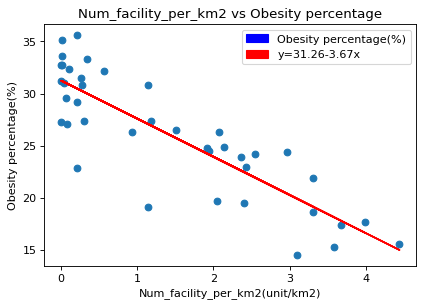

In [33]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['obese_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['obese_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Obesity percentage(%)','y=31.26-3.67x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Obesity percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num_facility_per_km2 vs Obesity percentage")
plt.show()
plt.savefig("obesity_linear")

quadratic log-scale

Coefficients:  [ 0.         -4.25529738 -0.69658723]

Intercept:  26.033092293773276

Coefficient of determination: 0.70


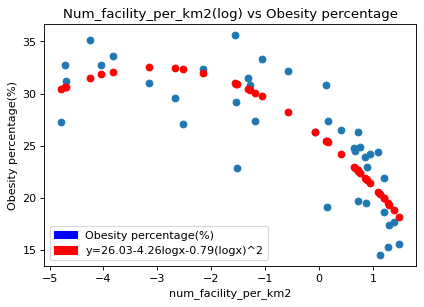

In [32]:
# log-scale quadratic linear regression
X = np.log(JOINED_2[['num_facility_per_km2']])
y = JOINED_2['obese_p_2_asr']
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

# R2
r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['Obesity percentage(%)','y=26.03-4.26logx-0.79(logx)^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num_facility_per_km2(log) vs Obesity percentage")
plt.ylabel("Obesity percentage(%)")
plt.xlabel("num_facility_per_km2")
plt.show()
plt.savefig("obesity_quadratic")

linear regression performs better

**Regression for hbld_pres_2_asr**

[[1.        0.2094712]
 [0.2094712 1.       ]]
Coefficients:  [0.62865202]

Intercept:  22.555969133782785

Coefficient of determination: 0.04


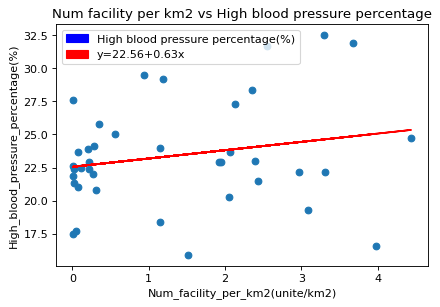

In [30]:
# exclude outliers
JOINED_NoOutlier = JOINED_2[JOINED_2['hbld_pres_2_asr']<35]
X = JOINED_NoOutlier[['num_facility_per_km2']]
y = JOINED_NoOutlier['hbld_pres_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['hbld_pres_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

#Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['High blood pressure percentage(%)','y=22.56+0.63x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("High_blood_pressure_percentage(%)")
plt.xlabel("Num_facility_per_km2(unite/km2)")
plt.title("Num facility per km2 vs High blood pressure percentage")
plt.show()
plt.savefig("highblood_linear")

**Regression for psych_dstrs_2_asr**

Linear

[[ 1.         -0.47607278]
 [-0.47607278  1.        ]]
Coefficients:  [-0.83790599]

Intercept:  13.24439771925698

Coefficient of determination: 0.23


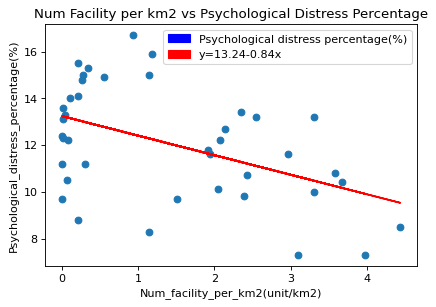

In [31]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['psych_dstrs_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['psych_dstrs_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Psychological distress percentage(%)','y=13.24-0.84x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Psychological_distress_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Psychological Distress Percentage")
plt.show()
plt.savefig("Psyc_linear")

quadratic

Coefficients:  [ 0.         1.4706014 -1.1203868]

Intercept:  66.64588417336479

Coefficient of determination: 0.55


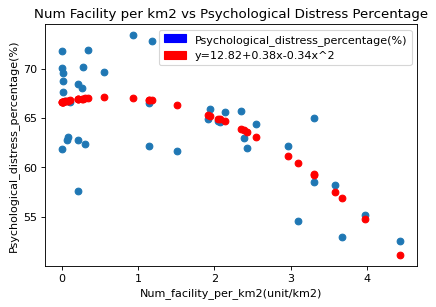

In [36]:
# quadratic linear regression
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

# R2
r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['Psychological_distress_percentage(%)','y=12.82+0.38x-0.34x^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Psychological_distress_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Psychological Distress Percentage")

plt.show()
plt.savefig("Psyc_queadratic")

In [94]:
# F-Test
import scipy.stats
mse = mean_squared_error(y, y_predict)
msr = sum((y_predict-y.mean())*(y_predict-y.mean()))/1
F = msr/mse
df1 = 2
df2 = JOINED_2.shape[0]-3 
p_value = 1 - scipy.stats.f.cdf(F, df1, df2)
print(p_value)

1.665345720069933e-05


num. of facility per km2 is statistically significant in modeling num of people with psychological distress

**Regression for smkrs_p_2_asr**

[[ 1.         -0.70782562]
 [-0.70782562  1.        ]]
Coefficients:  [-1.85374028]

Intercept:  17.976893441203515

Coefficient of determination: 0.53


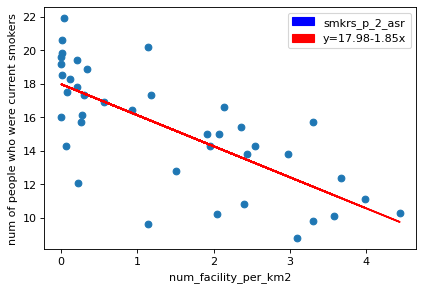

In [95]:

X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['smkrs_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['smkrs_p_2_asr']))

# Linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['smkrs_p_2_asr','y=17.98-1.85x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("num of people who were current smokers")
plt.xlabel("num_facility_per_km2")
plt.show()

**Regression for alchl_p_2_asr**

[[ 1.         -0.06628064]
 [-0.06628064  1.        ]]
Coefficients:  [-0.1644097]

Intercept:  15.72386817722047

Coefficient of determination: 0.00


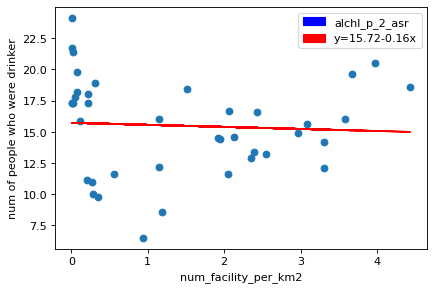

In [96]:

X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['alchl_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['alchl_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['alchl_p_2_asr','y=15.72-0.16x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("num of people who were drinker")
plt.xlabel("num_facility_per_km2")
plt.show()

slight association

**Regression for wst_meas_p_2_asr**

[[ 1.         -0.81370185]
 [-0.81370185  1.        ]]
Coefficients:  [-2.79719848]

Intercept:  65.06893621253013

Coefficient of determination: 0.67


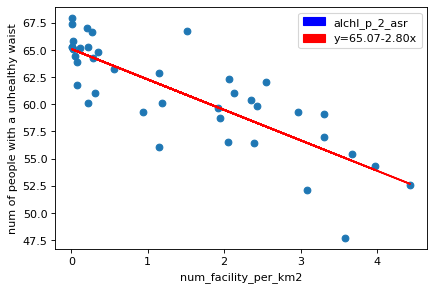

In [97]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['wst_meas_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['wst_meas_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['alchl_p_2_asr','y=65.07-2.80x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("num of people with a unhealthy waist")
plt.xlabel("num_facility_per_km2")
plt.show()

In [98]:
# percentage of facilities in each LGA by types of sports played
LGA_SPORT_FACILITY['total'] = LGA_SPORT_FACILITY.groupby('lga_code')['lga_code'].transform('count')
GROUPBY_LGA_AND_SPORT = LGA_SPORT_FACILITY.groupby(['lga_code','sportsplayed', 'total']).size().reset_index(name='count')
GROUPBY_LGA_AND_SPORT = GROUPBY_LGA_AND_SPORT.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)
GROUPBY_LGA_AND_SPORT['percentage'] = GROUPBY_LGA_AND_SPORT['count'] / GROUPBY_LGA_AND_SPORT['total']
TOP = GROUPBY_LGA_AND_SPORT.sort_values(['lw_excse_2_asr', 'lga_code', 'percentage'], ascending=[True, True, False]).groupby('lga_code')
pd.set_option('display.max_rows', 20)
TOP.head()

,sportsplayed,total,count,alchl_p_2_asr,hbld_pres_2_asr,ovrwgt_p_2_asr,lw_excse_2_asr,psych_dstrs_2_asr,smkrs_p_2_asr,obese_p_2_asr,wst_meas_p_2_asr,percentage
lga_code,,,,,,,,,,,,
26350,Cricket,114,21,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.184211
26350,Fitness / Gymnasium Workouts,114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
26350,Tennis (Outdoor),114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
26350,Australian Rules Football,114,9,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.078947
26350,Lawn Bowls,114,6,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...
22670,Cricket,121,26,6.5,29.5,36.9,73.4,16.7,16.4,26.3,59.3,0.214876
22670,Soccer,121,14,6.5,29.5,36.9,73.4,16.7,16.4,26.3,59.3,0.115702
22670,Australian Rules Football,121,13,6.5,29.5,36.9,73.4,16.7,16.4,26.3,59.3,0.107438


In [123]:
# take average of three obese-related metrics
# select 5 LGA with best performance
JOINED_2 = JOINED_2.reset_index()
JOINED_2['obese_risk'] = JOINED_2[['obese_p_2_asr','lw_excse_2_asr','wst_meas_p_2_asr']].mean(axis=1)

In [124]:
TOP5_LGA = JOINED_2.sort_values('obese_risk').iloc[:5,]['lga_code'].to_list()
TOP5_LGA

[26350, 21110, 24600, 25900, 20910]

In [125]:
# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)

,sportsplayed,total,count,alchl_p_2_asr,hbld_pres_2_asr,ovrwgt_p_2_asr,lw_excse_2_asr,psych_dstrs_2_asr,smkrs_p_2_asr,obese_p_2_asr,wst_meas_p_2_asr,percentage
lga_code,,,,,,,,,,,,
26350,Cricket,114,21,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.184211
26350,Fitness / Gymnasium Workouts,114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
26350,Tennis (Outdoor),114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
25900,Cricket,76,11,19.6,31.9,36.6,52.9,10.4,12.4,17.4,55.4,0.144737
25900,Tennis (Outdoor),76,8,19.6,31.9,36.6,52.9,10.4,12.4,17.4,55.4,0.105263
25900,Australian Rules Football,76,6,19.6,31.9,36.6,52.9,10.4,12.4,17.4,55.4,0.078947
24600,Fitness / Gymnasium Workouts,134,31,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.231343
24600,Cricket,134,13,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.097015
24600,Australian Rules Football,134,11,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.082090


Text(0.5, 0, 'LGA code')

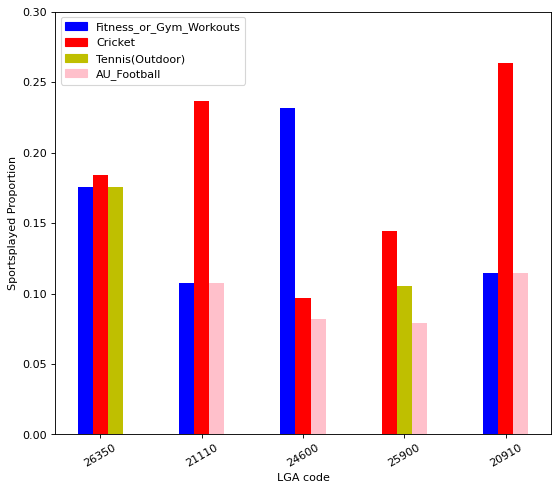

In [134]:
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.175439,0.107527,0.231343,0,0.114865]
Cricket = [0.184211,0.236559,0.097015,0.144737,0.263514]
Tennis_Outerdoor=[0.175439,0,0,0.105263,0]
AU_Football = [0,0.107527,0.082090,0.078947,0.114865]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0,0,0.3,0], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0,0,0.3,0],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3+[0.3,0,0,0,0],AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")

In [135]:
# select 5 LGA with best performance in psychological distress 
TOP5_LGA = JOINED_2.sort_values('psych_dstrs_2_asr').iloc[:5,]['lga_code'].to_list()
TOP5_LGA

[20910, 21110, 24210, 26350, 25710]

In [137]:
# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)

,sportsplayed,total,count,alchl_p_2_asr,hbld_pres_2_asr,ovrwgt_p_2_asr,lw_excse_2_asr,psych_dstrs_2_asr,smkrs_p_2_asr,obese_p_2_asr,wst_meas_p_2_asr,percentage
lga_code,,,,,,,,,,,,
26350,Cricket,114,21,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.184211
26350,Fitness / Gymnasium Workouts,114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
26350,Tennis (Outdoor),114,20,18.6,24.7,37.4,52.5,8.5,10.3,15.5,52.6,0.175439
25710,Cricket,95,19,18.0,22.9,39.5,57.6,8.8,12.1,22.8,60.1,0.200000
25710,Tennis (Outdoor),95,13,18.0,22.9,39.5,57.6,8.8,12.1,22.8,60.1,0.136842
25710,Australian Rules Football,95,11,18.0,22.9,39.5,57.6,8.8,12.1,22.8,60.1,0.115789
24210,Cricket,130,22,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.169231
24210,Australian Rules Football,130,18,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.138462
24210,Tennis (Outdoor),130,17,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.130769


Text(0.5, 0, 'LGA code')

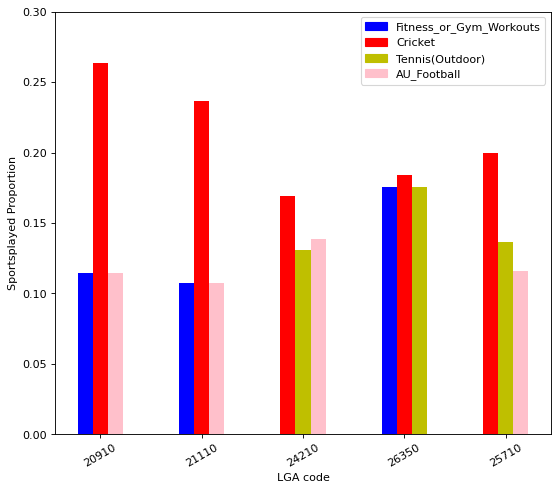

In [144]:
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.114865,0.107527,0,0.175439,0]
Cricket = [0.263514,0.236559,0.169231,0.184211,0.200000]
Tennis_Outerdoor=[0,0,0.130769,0.175439,0.136842]
AU_Football = [0.114865,0.107527,0.138462,0,0.115789]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0,0.3,0,0.3], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0,0.3,0,0.3],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3,AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")

In [146]:
# select 5 LGA with best performance in num of smokers
TOP5_LGA = JOINED_2.sort_values('smkrs_p_2_asr').iloc[:5,]['lga_code'].to_list()
TOP5_LGA

[21110, 24210, 22310, 24600, 24970]

In [147]:
# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)

,sportsplayed,total,count,alchl_p_2_asr,hbld_pres_2_asr,ovrwgt_p_2_asr,lw_excse_2_asr,psych_dstrs_2_asr,smkrs_p_2_asr,obese_p_2_asr,wst_meas_p_2_asr,percentage
lga_code,,,,,,,,,,,,
24970,Cricket,167,33,11.6,20.3,37.4,64.7,10.1,10.2,19.7,56.5,0.197605
24970,Australian Rules Football,167,19,11.6,20.3,37.4,64.7,10.1,10.2,19.7,56.5,0.113772
24970,Fitness / Gymnasium Workouts,167,17,11.6,20.3,37.4,64.7,10.1,10.2,19.7,56.5,0.101796
24600,Fitness / Gymnasium Workouts,134,31,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.231343
24600,Cricket,134,13,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.097015
24600,Australian Rules Football,134,11,16.0,43.1,33.0,58.2,10.8,10.1,15.3,47.7,0.082090
24210,Cricket,130,22,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.169231
24210,Australian Rules Football,130,18,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.138462
24210,Tennis (Outdoor),130,17,12.2,18.4,38.4,62.2,8.3,9.6,19.1,56.1,0.130769


Text(0.5, 0, 'LGA code')

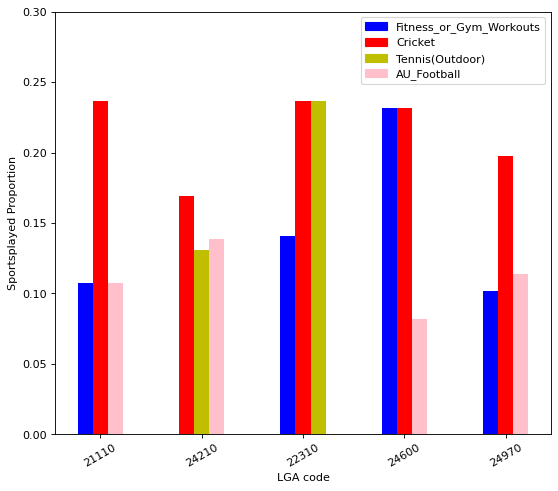

In [151]:
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.107527,0,0.140625,0.231343,0.101796]
Cricket = [0.236559,0.169231,0.236559,0.231343,0.197605]
Tennis_Outerdoor=[0,0.130769,0.236559,0,0]
AU_Football = [0.107527,0.138462,0,0.082090,0.113772]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0.3,0,0,0], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0.3,0,0,0],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3,AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")